# Libraries

In [2]:
#Libraries
import gymnasium as gym
from tetris_gymnasium.envs.tetris import Tetris
from tetris_gymnasium.envs.tetris import TetrisState
from tetris_gymnasium.wrappers.observation import FeatureVectorObservation

import sys
import cv2
import time
import numpy as np

import os

import neat
import pickle

#  Function to Have a Neural Network Play Tetris and Output Fitn

In [26]:
### Define function to have the neural network play Tetris and output the fitness
def eval_nn(i_net):
    '''
    #input the neural network which is dictated 
    '''

    if __name__ == "__main__":
        env = gym.make("tetris_gymnasium/Tetris", render_mode="ansi")
        env.reset()
        
        reward_hist = 0
        del_h_hist = 0

        terminated = False
        while not terminated:
            ### CODE TO GET THE HEIGHT AFTER EACH FRAME 
            #the board doesn't include the piece (the piece is a projection onto the board)
            env1 = FeatureVectorObservation(env) #create an instance of the class
            
            height_i = env1.calc_height(env.board) #call a function from the class with the board as an input
            height_i = (height_i[4:14])-4 #crop out the padding on either side (the bedrock) and normalize by the 4 layers of bedrock underneath
            prev_height = height_i
            #height_hist = np.vstack((height_hist,height_i)) #append to bottom of the historian

            ### Get the current tetromino in a list form and in the position relative to the other blocks
            tetromino = env.active_tetromino
            slices = env.get_tetromino_slices(tetromino, env.x, env.y)
            #Create pseudo_board of just zeros
            only_tetromino = np.zeros((24,18))
            #add the tetromino in its correct place
            only_tetromino[slices] += tetromino.matrix
            #Convert to 1s and 0s
            only_tetromino = np.where(only_tetromino > 0, 1, 0)
            #Sum in each column
            only_tetromino = np.sum(only_tetromino,axis=0)
            #Crop out the empty bedrock
            only_tetromino=only_tetromino[4:14]
            #print(only_tetromino)
            
            #compile the two features together
            i_feat = np.hstack((only_tetromino,height_i)) #this is a one dimensional list of 20 integers

            #Iterate to the next step
            action = np.argmax(i_net.activate(i_feat)) #input is a vector of length 20, and outputs a number 0-3
            if action ==2:
                action = 5
            observation, reward, terminated, truncated, info = env.step(action)
            
            #Running total of the fitness
            reward_hist+=reward
            
            #Calculate the holes after each frame --> Only need to return 
            holes_i = env1.calc_holes(env.board)

            #Calculate the change in max height only after a block is placed:
            if reward>0:
                #Calculate the new height of the board
                env1 = FeatureVectorObservation(env) #create an instance of the class
                height_new = env1.calc_height(env.board) #call a function from the class with the board as an input
                height_new = (height_new[4:14])-4
                #Find the difference in the height 
                max_h_index = np.argmax(height_new)
                i_del_h = height_new[max_h_index] - prev_height[max_h_index]
                
                #Assign height to previous height for the next step --> Didn't Work
                prev_height = height_new
                
                #Give positive reward if the height didn't change
                if i_del_h == 0:
                    del_h_hist += 2

    return float(reward_hist), holes_i, del_h_hist #the cumulative score at the end is the fitness

# Function to Generate and Evaluate Each Generation of Genes

In [29]:
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 0
        net_i = neat.nn.FeedForwardNetwork.create(genome, config)
        reward_i , holes_i, del_h_i= eval_nn(net_i)
        genome.fitness = del_h_i 
        
        #If the genome fitness is above 100, save as a pickle file
            # Save the winning_neural_network to a file
        if genome.fitness>100:
            with open(str(genome_id)+'.'+str(reward_i)+'.pkl', 'wb') as f:
                pickle.dump(net_i, f)

def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    # Run for up to 300 generations.
    winner = p.run(eval_genomes, 500)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

    # Show output
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)


    #node_names = {-1: 'A', -2: 'B', 0: 'A XOR B'}
    draw_net(config, winner, True)
    plot_stats(stats, ylog=False, view=True)
    plot_species(stats, view=True)
    
    
    #p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    #p.run(eval_genomes, 10)
    return winner_net

# Visualization of Species Fitness Statistics Over the Generations

In [28]:
import warnings

import graphviz
import matplotlib.pyplot as plt
import numpy as np


def plot_stats(statistics, ylog=False, view=False, filename='avg_fitness.svg'):
    """ Plots the population's average and best fitness. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())

    plt.plot(generation, avg_fitness, 'b-', label="average")
    plt.plot(generation, avg_fitness - stdev_fitness, 'g-.', label="-1 sd")
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label="+1 sd")
    plt.plot(generation, best_fitness, 'r-', label="best")

    plt.title("Population's average and best fitness")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    if ylog:
        plt.gca().set_yscale('symlog')

    plt.savefig(filename)
    if view:
        plt.show()

    plt.close()


def plot_spikes(spikes, view=False, filename=None, title=None):
    """ Plots the trains for a single spiking neuron. """
    t_values = [t for t, I, v, u, f in spikes]
    v_values = [v for t, I, v, u, f in spikes]
    u_values = [u for t, I, v, u, f in spikes]
    I_values = [I for t, I, v, u, f in spikes]
    f_values = [f for t, I, v, u, f in spikes]

    fig = plt.figure()
    plt.subplot(4, 1, 1)
    plt.ylabel("Potential (mv)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, v_values, "g-")

    if title is None:
        plt.title("Izhikevich's spiking neuron model")
    else:
        plt.title("Izhikevich's spiking neuron model ({0!s})".format(title))

    plt.subplot(4, 1, 2)
    plt.ylabel("Fired")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, f_values, "r-")

    plt.subplot(4, 1, 3)
    plt.ylabel("Recovery (u)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, u_values, "r-")

    plt.subplot(4, 1, 4)
    plt.ylabel("Current (I)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, I_values, "r-o")

    if filename is not None:
        plt.savefig(filename)

    if view:
        plt.show()
        plt.close()
        fig = None

    return fig


def plot_species(statistics, view=False, filename='speciation.svg'):
    """ Visualizes speciation throughout evolution. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    species_sizes = statistics.get_species_sizes()
    num_generations = len(species_sizes)
    curves = np.array(species_sizes).T

    fig, ax = plt.subplots()
    ax.stackplot(range(num_generations), *curves)

    plt.title("Speciation")
    plt.ylabel("Size per Species")
    plt.xlabel("Generations")

    plt.savefig(filename)

    if view:
        plt.show()

    plt.close()


def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    # If requested, use a copy of the genome which omits all components that won't affect the output.
    if prune_unused:
        genome = genome.get_pruned_copy(config.genome_config)

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled', 'shape': 'box', 'fillcolor': node_colors.get(k, 'lightgray')}
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled', 'fillcolor': node_colors.get(k, 'lightblue')}

        dot.node(name, _attributes=node_attrs)

    used_nodes = set(genome.nodes.keys())
    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            # if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)

    return dot


# Run the NEAT Algorithm Using the Specific Configuration File and Save Winning Neural Network in a Pickle File


 ****** Running generation 0 ****** 

Population's average fitness: 2.45333 stdev: 3.71050
Best fitness: 22.00000 - size: (20, 384) - species 63 - id 63
Average adjusted fitness: 0.112
Mean genetic distance 3.675, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0     2      2.0    0.091     0
     2    0     2     10.0    0.455     0
     3    0     2      0.0    0.000     0
     4    0     2      0.0    0.000     0
     5    0     2      8.0    0.364     0
     6    0     2      0.0    0.000     0
     7    0     2      0.0    0.000     0
     8    0     2      2.0    0.091     0
     9    0     2      8.0    0.364     0
    10    0     2      0.0    0.000     0
    11    0     2      0.0    0.000     0
    12    0     2      2.0    0.091     0
    13    0     2      2.0    0.091     0
    14    0     2      0.0    0.000     0
    15    0     2      2.0    0.091     0
    

Population's average fitness: 2.86667 stdev: 4.09173
Best fitness: 20.00000 - size: (20, 384) - species 37 - id 37
Average adjusted fitness: 0.143
Mean genetic distance 3.675, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    2     2      4.0    0.150     1
     2    2     2      6.0    0.150     1
     3    2     2      0.0    0.000     2
     4    2     2     10.0    0.250     0
     5    2     2     12.0    0.550     1
     6    2     2      0.0    0.000     2
     7    2     2      2.0    0.050     0
     8    2     2      6.0    0.150     1
     9    2     2      6.0    0.300     2
    10    2     2      6.0    0.150     0
    11    2     2      0.0    0.000     2
    12    2     2      2.0    0.050     1
    13    2     2      0.0    0.000     2
    14    2     2      2.0    0.050     0
    15    2     2      0.0    0.000     2
    16    2     2      8.0    0.250     2
 

Population's average fitness: 2.66667 stdev: 4.32152
Best fitness: 24.00000 - size: (21, 380) - species 139 - id 291
Average adjusted fitness: 0.111
Mean genetic distance 3.675, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    4     2     12.0    0.292     1
     2    4     2      2.0    0.042     3
     3    4     2      0.0    0.000     4
     4    4     2      4.0    0.167     1
     5    4     2     16.0    0.458     0
     6    4     2      0.0    0.000     4
     7    4     2      0.0    0.000     2
     8    4     2      8.0    0.167     3
     9    4     2     10.0    0.375     0
    10    4     2      0.0    0.000     2
    11    4     2      0.0    0.000     4
    12    4     2      2.0    0.083     1
    13    4     2      0.0    0.000     4
    14    4     2      0.0    0.000     1
    15    4     2      0.0    0.000     4
    16    4     2     16.0    0.333     0

Population's average fitness: 3.00667 stdev: 4.50629
Best fitness: 24.00000 - size: (20, 379) - species 79 - id 242
Average adjusted fitness: 0.125
Mean genetic distance 3.675, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    6     2      2.0    0.042     3
     2    6     2      8.0    0.167     5
     3    6     2      0.0    0.000     6
     4    6     2     12.0    0.250     3
     5    6     2     18.0    0.625     0
     6    6     2      0.0    0.000     6
     7    6     2      2.0    0.042     4
     8    6     2      4.0    0.125     5
     9    6     2      6.0    0.208     2
    10    6     2      6.0    0.125     4
    11    6     2      0.0    0.000     6
    12    6     2      4.0    0.125     3
    13    6     2      4.0    0.125     0
    14    6     2     12.0    0.250     0
    15    6     2      2.0    0.042     6
    16    6     2      4.0    0.083     2


Population's average fitness: 2.83333 stdev: 3.85904
Best fitness: 24.00000 - size: (20, 383) - species 69 - id 187
Average adjusted fitness: 0.118
Mean genetic distance 3.675, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    8     2     10.0    0.292     5
     2    8     2      6.0    0.125     7
     3    8     2      0.0    0.000     8
     4    8     2      8.0    0.250     5
     5    8     2     12.0    0.417     2
     6    8     2      0.0    0.000     8
     7    8     2      0.0    0.000     6
     8    8     2      4.0    0.125     7
     9    8     2     12.0    0.333     0
    10    8     2      0.0    0.000     6
    11    8     2      0.0    0.000     8
    12    8     2      4.0    0.125     1
    13    8     2      2.0    0.042     1
    14    8     2      0.0    0.000     2
    15    8     2      2.0    0.042     8
    16    8     2      8.0    0.250     4



 ****** Running generation 10 ****** 

Population's average fitness: 2.94667 stdev: 4.37079
Best fitness: 28.00000 - size: (20, 383) - species 69 - id 187
Average adjusted fitness: 0.105
Mean genetic distance 3.675, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   10     2     14.0    0.286     1
     2   10     2      4.0    0.071     9
     3   10     2      0.0    0.000    10
     4   10     2     12.0    0.250     7
     5   10     2      4.0    0.143     4
     6   10     2      2.0    0.036     0
     7   10     2      0.0    0.000     8
     8   10     2      0.0    0.000     9
     9   10     2      8.0    0.286     2
    10   10     2     10.0    0.250     0
    11   10     2      0.0    0.000    10
    12   10     2      6.0    0.143     3
    13   10     2      4.0    0.071     3
    14   10     2      4.0    0.071     4
    15   10     2      2.0    0.036    10
  

Population's average fitness: 2.56667 stdev: 3.73259
Best fitness: 16.00000 - size: (20, 384) - species 31 - id 31
Average adjusted fitness: 0.160
Mean genetic distance 3.675, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   12     2      8.0    0.250     3
     2   12     2      8.0    0.250    11
     3   12     2      0.0    0.000    12
     4   12     2      6.0    0.250     9
     5   12     2     14.0    0.750     6
     6   12     2      0.0    0.000     2
     7   12     2      0.0    0.000    10
     8   12     2      8.0    0.250     1
     9   12     2      6.0    0.375     4
    10   12     2      0.0    0.000     2
    11   12     2      0.0    0.000    12
    12   12     2      2.0    0.125     5
    13   12     2      8.0    0.312     5
    14   12     2      0.0    0.000     6
    15   12     2      0.0    0.000    12
    16   12     2      4.0    0.250     8
 

Population's average fitness: 2.84667 stdev: 4.12995
Best fitness: 20.00000 - size: (20, 384) - species 63 - id 63
Average adjusted fitness: 0.142
Mean genetic distance 3.675, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   14     2     18.0    0.500     0
     2   14     2      4.0    0.150    13
     3   14     2      0.0    0.000     1
     4   14     2     12.0    0.350    11
     5   14     2     10.0    0.400     8
     6   14     2      0.0    0.000     4
     7   14     2      0.0    0.000    12
     8   14     2      4.0    0.150     3
     9   14     2      8.0    0.300     6
    10   14     2      2.0    0.050     4
    11   14     2      0.0    0.000    14
    12   14     2      2.0    0.100     7
    13   14     2      2.0    0.050     7
    14   14     2      0.0    0.000     8
    15   14     2      0.0    0.000    14
    16   14     2     12.0    0.300    10
 

Population's average fitness: 2.88667 stdev: 4.36354
Best fitness: 22.00000 - size: (19, 358) - species 62 - id 239
Average adjusted fitness: 0.131
Mean genetic distance 3.675, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   16     2      8.0    0.227     2
     2   16     2     12.0    0.318    15
     3   16     2      0.0    0.000     3
     4   16     2     14.0    0.409     0
     5   16     2     10.0    0.318    10
     6   16     2      2.0    0.045     6
     7   16     2      0.0    0.000    14
     8   16     2      6.0    0.182     5
     9   16     2      4.0    0.182     1
    10   16     2      0.0    0.000     6
    11   16     2      0.0    0.000    16
    12   16     2      2.0    0.045     9
    13   16     2      2.0    0.045     9
    14   16     2      0.0    0.000    10
    15   16     2      2.0    0.045    16
    16   16     2      8.0    0.182    12


Population's average fitness: 2.58667 stdev: 3.80909
Best fitness: 18.00000 - size: (20, 383) - species 69 - id 187
Average adjusted fitness: 0.144
Mean genetic distance 3.675, standard deviation 0.284
Population of 300 members in 150 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18     2      8.0    0.278     4
     2   18     2      0.0    0.000    17
     3   18     2      0.0    0.000     5
     4   18     2     10.0    0.333     2
     5   18     2     12.0    0.556    12
     6   18     2      0.0    0.000     8
     7   18     2      0.0    0.000    16
     8   18     2      6.0    0.167     7
     9   18     2      6.0    0.278     3
    10   18     2      6.0    0.167     8
    11   18     2      0.0    0.000    18
    12   18     2      0.0    0.000    11
    13   18     2      6.0    0.167    11
    14   18     2      6.0    0.167    12
    15   18     2      0.0    0.000    18
    16   18     2      4.0    0.167    14



 ****** Running generation 20 ****** 

Population's average fitness: 2.70000 stdev: 3.92980
Best fitness: 22.00000 - size: (20, 384) - species 63 - id 63

Species 11 with 2 members is stagnated: removing it

Species 18 with 2 members is stagnated: removing it

Species 25 with 2 members is stagnated: removing it

Species 26 with 2 members is stagnated: removing it

Species 47 with 2 members is stagnated: removing it

Species 49 with 2 members is stagnated: removing it

Species 64 with 2 members is stagnated: removing it

Species 75 with 2 members is stagnated: removing it

Species 77 with 2 members is stagnated: removing it

Species 83 with 2 members is stagnated: removing it

Species 114 with 2 members is stagnated: removing it

Species 133 with 2 members is stagnated: removing it

Species 15 with 2 members is stagnated: removing it

Species 143 with 2 members is stagnated: removing it

Species 78 with 2 members is stagnated: removing it
Average adjusted fitness: 0.136
Mean genetic di

Population's average fitness: 2.86066 stdev: 3.95842
Best fitness: 18.00000 - size: (19, 358) - species 62 - id 239

Species 7 with 2 members is stagnated: removing it

Species 74 with 2 members is stagnated: removing it

Species 127 with 2 members is stagnated: removing it

Species 60 with 2 members is stagnated: removing it

Species 19 with 2 members is stagnated: removing it

Species 147 with 2 members is stagnated: removing it

Species 44 with 2 members is stagnated: removing it

Species 117 with 2 members is stagnated: removing it

Species 53 with 2 members is stagnated: removing it

Species 66 with 2 members is stagnated: removing it

Species 87 with 2 members is stagnated: removing it
Average adjusted fitness: 0.167
Mean genetic distance 3.669, standard deviation 0.328
Population of 222 members in 111 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   22     2     12.0    0.556     8
     3   22     2      0.0    0.000     9
   

Population's average fitness: 2.91787 stdev: 4.33701
Best fitness: 24.00000 - size: (20, 383) - species 69 - id 187

Species 102 with 2 members is stagnated: removing it

Species 88 with 2 members is stagnated: removing it

Species 38 with 2 members is stagnated: removing it

Species 131 with 2 members is stagnated: removing it

Species 70 with 2 members is stagnated: removing it

Species 148 with 2 members is stagnated: removing it

Species 16 with 2 members is stagnated: removing it

Species 93 with 2 members is stagnated: removing it

Species 139 with 2 members is stagnated: removing it
Average adjusted fitness: 0.113
Mean genetic distance 3.663, standard deviation 0.354
Population of 194 members in 94 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   24     2      8.0    0.250    10
     3   24     2      0.0    0.000    11
     4   24     2      6.0    0.208     8
     5   24     3     16.0    0.417    18
     6   24     2      0

Population's average fitness: 2.65969 stdev: 3.74087
Best fitness: 22.00000 - size: (20, 383) - species 69 - id 187

Species 27 with 2 members is stagnated: removing it

Species 14 with 2 members is stagnated: removing it

Species 29 with 2 members is stagnated: removing it

Species 150 with 2 members is stagnated: removing it

Species 96 with 2 members is stagnated: removing it

Species 129 with 2 members is stagnated: removing it

Species 52 with 2 members is stagnated: removing it

Species 79 with 2 members is stagnated: removing it

Species 5 with 3 members is stagnated: removing it
Average adjusted fitness: 0.117
Mean genetic distance 3.659, standard deviation 0.375
Population of 173 members in 83 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   26     2      8.0    0.227    12
     3   26     2      0.0    0.000    13
     4   26     2     10.0    0.273    10
     6   26     2      0.0    0.000    16
     8   26     2      6.0 

Population's average fitness: 3.05455 stdev: 4.15788
Best fitness: 24.00000 - size: (21, 380) - species 69 - id 320

Species 125 with 2 members is stagnated: removing it

Species 45 with 2 members is stagnated: removing it

Species 65 with 2 members is stagnated: removing it
Average adjusted fitness: 0.120
Mean genetic distance 3.648, standard deviation 0.401
Population of 165 members in 74 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   28     2      6.0    0.139    14
     3   28     2      0.0    0.000    15
     4   28     2     10.0    0.250    12
     6   28     2      0.0    0.000    18
     8   28     2      8.0    0.167    17
     9   28     3     10.0    0.375    13
    10   28     2     14.0    0.292     0
    21   28     4     10.0    0.417    15
    23   28     2      0.0    0.000    15
    28   28     2      8.0    0.167    15
    30   28     3      8.0    0.194     4
    31   28     3     16.0    0.375    12
    32   

Population's average fitness: 3.27273 stdev: 3.92098
Best fitness: 22.00000 - size: (19, 358) - species 62 - id 239

Species 8 with 3 members is stagnated: removing it

Species 136 with 5 members is stagnated: removing it

Species 35 with 5 members is stagnated: removing it
Average adjusted fitness: 0.112
Mean genetic distance 3.634, standard deviation 0.428
Population of 161 members in 60 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   31     5     16.0    0.394    17
     3   31     2      0.0    0.000    18
     4   31     3      4.0    0.136    15
     9   31     4     12.0    0.295    16
    10   31     3      6.0    0.136     3
    21   31     3     10.0    0.242    18
    23   31     2      6.0    0.121    18
    28   31     3      4.0    0.091    18
    30   31     3     10.0    0.242     7
    31   31     3      8.0    0.212    15
    32   31     2      2.0    0.045    11
    33   31     2      2.0    0.045    14
    34   3

Population's average fitness: 4.42500 stdev: 5.64087
Best fitness: 28.00000 - size: (21, 383) - species 95 - id 489

Species 51 with 2 members is stagnated: removing it

Species 40 with 3 members is stagnated: removing it

Species 1 with 4 members is stagnated: removing it
Average adjusted fitness: 0.120
Mean genetic distance 3.599, standard deviation 0.483
Population of 158 members in 47 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     4   34     5     10.0    0.243    18
     9   34     4      8.0    0.157    19
    10   34     2      6.0    0.071     6
    28   34     6     14.0    0.238     1
    30   34     4     14.0    0.171    10
    31   34     7     22.0    0.393     0
    32   34     2      0.0    0.000    14
    33   34     4     10.0    0.190     0
    34   34     5     14.0    0.179     0
    42   34     3      4.0    0.107    15
    43   34     2      0.0    0.000    17
    54   34     4     12.0    0.214    19
    55   34

Population's average fitness: 6.33113 stdev: 6.75956
Best fitness: 32.00000 - size: (22, 371) - species 55 - id 843

Species 90 with 2 members is stagnated: removing it

Species 82 with 6 members is stagnated: removing it

Species 110 with 4 members is stagnated: removing it
Average adjusted fitness: 0.146
Mean genetic distance 3.540, standard deviation 0.582
Population of 151 members in 28 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    10   38     3      6.0    0.125    10
    28   38    11     22.0    0.344     2
    30   38     4     10.0    0.113    14
    31   38    11     26.0    0.287     0
    32   38     3      6.0    0.125    18
    33   38     6     22.0    0.234     0
    34   38     2      2.0    0.031     4
    42   38     6     12.0    0.200    19
    55   38    13     32.0    0.370     0
    59   38     2      0.0    0.000    17
    61   38     3      4.0    0.047     9
    67   38     6     10.0    0.125     1
    72   

Population's average fitness: 7.55862 stdev: 6.67045
Best fitness: 32.00000 - size: (20, 380) - species 137 - id 516

Species 30 with 6 members is stagnated: removing it
Average adjusted fitness: 0.210
Mean genetic distance 3.444, standard deviation 0.668
Population of 148 members in 19 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    10   44    10     20.0    0.285     3
    28   44     9     18.0    0.281     8
    31   44     8     18.0    0.188     6
    33   44     7     18.0    0.250     6
    34   44     2      4.0    0.042    10
    55   44    13     24.0    0.328     6
    61   44     3      2.0    0.016    15
    67   44    10     18.0    0.243     1
    72   44    10     22.0    0.297     2
    84   44    11     20.0    0.319     5
    95   44     6     14.0    0.203    10
    97   44     3      4.0    0.062    19
   108   44     8     14.0    0.205     3
   109   44    11     18.0    0.319     1
   119   44     3      6.0    0

Population's average fitness: 7.70470 stdev: 6.51843
Best fitness: 24.00000 - size: (18, 329) - species 124 - id 1190
Average adjusted fitness: 0.322
Mean genetic distance 3.435, standard deviation 0.688
Population of 149 members in 17 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    10   51    12     20.0    0.363     2
    28   51    10     20.0    0.343     1
    31   51     9     18.0    0.283    13
    33   51     9     14.0    0.450    13
    34   51     6     12.0    0.214     2
    55   51    11     24.0    0.410    13
    61   51     3      4.0    0.104     6
    67   51     9     22.0    0.323     8
    72   51    10     24.0    0.326     9
    84   51    12     22.0    0.619    12
    95   51     8     16.0    0.269    17
   108   51    10     20.0    0.389     5
   109   51     8     10.0    0.159     5
   124   51     8     24.0    0.333     3
   137   51     8     12.0    0.182    12
   138   51     9     18.0    0.429    14

Mean genetic distance 3.358, standard deviation 0.792
Population of 150 members in 12 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    10   58     9     18.0    0.222     9
    28   58    12     20.0    0.315     8
    34   58    11     22.0    0.316     0
    61   58    11     18.0    0.316     0
    67   58    12     22.0    0.325    15
    72   58    14     22.0    0.362    16
    84   58    12     16.0    0.325    19
   108   58    15     26.0    0.397    12
   109   58    11     18.0    0.282    12
   124   58    14     18.0    0.371    10
   137   58    14     24.0    0.346    19
   146   58    15     22.0    0.415     3
Total extinctions: 0
Generation time: 22.154 sec (22.992 average)

 ****** Running generation 59 ****** 

Population's average fitness: 7.62667 stdev: 6.64284
Best fitness: 26.00000 - size: (20, 292) - species 84 - id 3080

Species 137 with 14 members is stagnated: removing it
Average adjusted fitness: 0.285
Mean ge

Population's average fitness: 7.32000 stdev: 6.21323
Best fitness: 24.00000 - size: (20, 289) - species 28 - id 4038

Species 124 with 14 members is stagnated: removing it
Average adjusted fitness: 0.308
Mean genetic distance 3.202, standard deviation 0.888
Population of 151 members in 7 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    10   68    14     14.0    0.144    19
    28   68    21     24.0    0.381     5
    34   68    24     20.0    0.330     4
    61   68    22     18.0    0.261     6
    67   68    25     22.0    0.385     5
    72   68    23     18.0    0.351     7
   146   68    22     16.0    0.307    13
Total extinctions: 0
Generation time: 22.518 sec (22.800 average)

 ****** Running generation 69 ****** 

Population's average fitness: 8.01325 stdev: 7.19638
Best fitness: 30.00000 - size: (23, 288) - species 72 - id 4435

Species 10 with 14 members is stagnated: removing it
Average adjusted fitness: 0.273
Mean genetic di

Population's average fitness: 8.90667 stdev: 7.01840
Best fitness: 24.00000 - size: (19, 232) - species 28 - id 5950
Average adjusted fitness: 0.365
Mean genetic distance 3.084, standard deviation 0.901
Population of 150 members in 5 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    28   80    35     24.0    0.500    17
    34   80    31     22.0    0.359    16
    61   80    23     18.0    0.214     6
    67   80    25     20.0    0.298    17
    72   80    36     24.0    0.455    19
Total extinctions: 0
Generation time: 22.926 sec (22.165 average)

 ****** Running generation 81 ****** 

Population's average fitness: 7.62667 stdev: 6.79367
Best fitness: 26.00000 - size: (18, 214) - species 28 - id 6120

Species 72 with 36 members is stagnated: removing it
Average adjusted fitness: 0.299
Mean genetic distance 2.902, standard deviation 0.971
Population of 149 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ==== 


 ****** Running generation 95 ****** 

Population's average fitness: 8.81333 stdev: 6.70958
Best fitness: 26.00000 - size: (15, 106) - species 28 - id 8075
Average adjusted fitness: 0.338
Mean genetic distance 2.434, standard deviation 0.659
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    28   95    78     26.0    0.352    11
    61   95    72     24.0    0.325    21
Total extinctions: 0
Generation time: 19.278 sec (19.889 average)

 ****** Running generation 96 ****** 

Population's average fitness: 8.21333 stdev: 6.98626
Best fitness: 24.00000 - size: (21, 269) - species 61 - id 7909
Average adjusted fitness: 0.341
Mean genetic distance 2.379, standard deviation 0.651
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    28   96    79     24.0    0.365    12
    61   96    71     24.0    0.317    22
Total extinctions: 0
Generation 

Population's average fitness: 9.24000 stdev: 7.04148
Best fitness: 26.00000 - size: (16, 100) - species 28 - id 10459
Average adjusted fitness: 0.348
Mean genetic distance 2.473, standard deviation 0.656
Population of 151 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    28  111    71     26.0    0.413    10
    61  111    45     24.0    0.260     9
   151    1    35     22.0    0.370     0
Total extinctions: 0
Generation time: 15.748 sec (17.253 average)

 ****** Running generation 112 ****** 

Population's average fitness: 9.48344 stdev: 7.39237
Best fitness: 34.00000 - size: (19, 169) - species 61 - id 10600
Average adjusted fitness: 0.280
Mean genetic distance 2.416, standard deviation 0.655
Population of 150 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    28  112    62     26.0    0.302    11
    61  112    39     34.0    0.186     0
   151    2    49     26.0 

Population's average fitness: 9.86667 stdev: 6.95382
Best fitness: 30.00000 - size: (21, 192) - species 61 - id 12299
Average adjusted fitness: 0.325
Mean genetic distance 2.425, standard deviation 0.619
Population of 151 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    28  126    55     26.0    0.352    25
    61  126    43     30.0    0.276    14
   151   16    53     22.0    0.347     2
Total extinctions: 0
Generation time: 14.964 sec (15.411 average)

 ****** Running generation 127 ****** 

Population's average fitness: 9.45695 stdev: 7.10166
Best fitness: 26.00000 - size: (12, 65) - species 151 - id 12729
Average adjusted fitness: 0.359
Mean genetic distance 2.435, standard deviation 0.641
Population of 150 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    28  127    58     24.0    0.439    26
    61  127    42     22.0    0.297    15
   151   17    50     26.0 

Population's average fitness: 10.50667 stdev: 7.63566
Best fitness: 30.00000 - size: (24, 194) - species 61 - id 14895
Average adjusted fitness: 0.346
Mean genetic distance 2.351, standard deviation 0.570
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    61  142    66     30.0    0.321    30
   151   32    84     30.0    0.372     5
Total extinctions: 0
Generation time: 15.981 sec (16.305 average)

 ****** Running generation 143 ****** 

Population's average fitness: 9.06667 stdev: 7.21357
Best fitness: 26.00000 - size: (17, 74) - species 151 - id 15114
Average adjusted fitness: 0.342
Mean genetic distance 2.424, standard deviation 0.526
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    61  143    65     24.0    0.290    31
   151   33    85     26.0    0.395     6
Total extinctions: 0
Generation time: 15.667 sec (16.200 average)

 

Population's average fitness: 10.53333 stdev: 8.08180
Best fitness: 36.00000 - size: (15, 52) - species 151 - id 17326
Average adjusted fitness: 0.273
Mean genetic distance 2.299, standard deviation 0.650
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    61  158    55     22.0    0.205    46
   151   48    95     36.0    0.340    13
Total extinctions: 0
Generation time: 14.303 sec (15.397 average)

 ****** Running generation 159 ****** 

Population's average fitness: 10.77333 stdev: 8.69877
Best fitness: 34.00000 - size: (15, 44) - species 151 - id 17424
Average adjusted fitness: 0.291
Mean genetic distance 2.275, standard deviation 0.611
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    61  159    52     28.0    0.193    47
   151   49    98     34.0    0.389    14
Total extinctions: 0
Generation time: 13.758 sec (15.075 average)
S

Population's average fitness: 13.28000 stdev: 8.47043
Best fitness: 28.00000 - size: (12, 36) - species 151 - id 19620
Average adjusted fitness: 0.456
Mean genetic distance 2.210, standard deviation 0.611
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    61  174    60     22.0    0.357    62
   151   64    90     28.0    0.555    29
Total extinctions: 0
Generation time: 14.748 sec (14.241 average)
Saving checkpoint to neat-checkpoint-174

 ****** Running generation 175 ****** 

Population's average fitness: 12.01333 stdev: 8.31544
Best fitness: 30.00000 - size: (12, 36) - species 151 - id 19620
Average adjusted fitness: 0.383
Mean genetic distance 2.195, standard deviation 0.631
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    61  175    59     24.0    0.297    63
   151   65    91     30.0    0.470    30
Total extinctions: 0
Gener


 ****** Running generation 190 ****** 

Population's average fitness: 12.70667 stdev: 8.16215
Best fitness: 30.00000 - size: (15, 49) - species 151 - id 22003
Average adjusted fitness: 0.414
Mean genetic distance 2.346, standard deviation 0.563
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    61  190    63     26.0    0.349    78
   151   80    87     30.0    0.479    45
Total extinctions: 0
Generation time: 14.201 sec (14.190 average)

 ****** Running generation 191 ****** 

Population's average fitness: 12.65333 stdev: 8.81966
Best fitness: 32.00000 - size: (23, 105) - species 61 - id 21957
Average adjusted fitness: 0.391
Mean genetic distance 2.352, standard deviation 0.552
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    61  191    66     32.0    0.361    79
   151   81    84     32.0    0.420    46
Total extinctions: 0
Gener

Population's average fitness: 13.72000 stdev: 8.10277
Best fitness: 32.00000 - size: (16, 47) - species 151 - id 24323
Average adjusted fitness: 0.414
Mean genetic distance 2.716, standard deviation 0.804
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    61  206    61     26.0    0.351    94
   151   96    89     32.0    0.478    13
Total extinctions: 0
Generation time: 14.604 sec (14.211 average)

 ****** Running generation 207 ****** 

Population's average fitness: 11.18667 stdev: 8.02362
Best fitness: 32.00000 - size: (16, 47) - species 151 - id 24323
Average adjusted fitness: 0.345
Mean genetic distance 2.772, standard deviation 0.683
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
    61  207    65     24.0    0.320    95
   151   97    85     32.0    0.370    14
Total extinctions: 0
Generation time: 12.905 sec (14.013 average)



Population's average fitness: 14.29333 stdev: 9.06976
Best fitness: 36.00000 - size: (15, 28) - species 151 - id 26636
Average adjusted fitness: 0.397
Mean genetic distance 2.274, standard deviation 0.437
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  112    82     36.0    0.401    29
   152   14    68     34.0    0.393     1
Total extinctions: 0
Generation time: 11.604 sec (12.170 average)

 ****** Running generation 223 ****** 

Population's average fitness: 15.40000 stdev: 9.11775
Best fitness: 34.00000 - size: (14, 25) - species 151 - id 26789
Average adjusted fitness: 0.452
Mean genetic distance 2.281, standard deviation 0.483
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  113    77     34.0    0.461    30
   152   15    73     32.0    0.443     2
Total extinctions: 0
Generation time: 12.398 sec (12.154 average)



Population's average fitness: 15.78667 stdev: 9.22069
Best fitness: 32.00000 - size: (10, 19) - species 152 - id 28939
Average adjusted fitness: 0.493
Mean genetic distance 2.343, standard deviation 0.496
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  128    98     32.0    0.495    13
   152   30    52     32.0    0.491    17
Total extinctions: 0
Generation time: 12.554 sec (12.307 average)

 ****** Running generation 239 ****** 

Population's average fitness: 16.08000 stdev: 8.46603
Best fitness: 32.00000 - size: (15, 29) - species 152 - id 29120
Average adjusted fitness: 0.502
Mean genetic distance 2.452, standard deviation 0.567
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  129    85     32.0    0.503    14
   152   31    65     32.0    0.501    18
Total extinctions: 0
Generation time: 12.986 sec (12.350 average)
S

Population's average fitness: 15.54667 stdev: 9.41813
Best fitness: 36.00000 - size: (20, 37) - species 151 - id 31162
Average adjusted fitness: 0.432
Mean genetic distance 2.287, standard deviation 0.605
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  143    79     36.0    0.413    28
   153   10    71     32.0    0.450     3
Total extinctions: 0
Generation time: 11.922 sec (12.313 average)

 ****** Running generation 254 ****** 

Population's average fitness: 15.81333 stdev: 8.87948
Best fitness: 36.00000 - size: (15, 20) - species 153 - id 31294
Average adjusted fitness: 0.440
Mean genetic distance 2.083, standard deviation 0.638
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  144    76     32.0    0.431    29
   153   11    74     36.0    0.448     0
Total extinctions: 0
Generation time: 12.037 sec (12.326 average)
S

Population's average fitness: 15.78667 stdev: 9.45769
Best fitness: 38.00000 - size: (19, 35) - species 151 - id 33488
Average adjusted fitness: 0.415
Mean genetic distance 2.491, standard deviation 0.651
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  159    74     38.0    0.404    44
   153   26    76     34.0    0.426     7
Total extinctions: 0
Generation time: 12.353 sec (12.383 average)
Saving checkpoint to neat-checkpoint-269

 ****** Running generation 270 ****** 

Population's average fitness: 13.98667 stdev: 9.54288
Best fitness: 34.00000 - size: (18, 30) - species 153 - id 33569
Average adjusted fitness: 0.412
Mean genetic distance 2.508, standard deviation 0.673
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   151  160    76     30.0    0.428    45
   153   27    74     34.0    0.396     8
Total extinctions: 0
Gener

Population's average fitness: 15.46667 stdev: 10.36061
Best fitness: 34.00000 - size: (16, 30) - species 154 - id 35852

Species 153 with 68 members is stagnated: removing it
Average adjusted fitness: 0.443
Mean genetic distance 2.327, standard deviation 0.361
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   154   14    94     34.0    0.452     6
   155    1    56     32.0    0.434     0
Total extinctions: 0
Generation time: 11.979 sec (12.069 average)

 ****** Running generation 286 ****** 

Population's average fitness: 15.82667 stdev: 10.07157
Best fitness: 36.00000 - size: (16, 28) - species 154 - id 35920
Average adjusted fitness: 0.428
Mean genetic distance 2.215, standard deviation 0.296
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   154   15    59     36.0    0.475     7
   155    2    91     34.0    0.381     0
Total exti

Population's average fitness: 15.45333 stdev: 9.70745
Best fitness: 34.00000 - size: (21, 32) - species 154 - id 38136
Average adjusted fitness: 0.398
Mean genetic distance 2.339, standard deviation 0.428
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   154   30    88     34.0    0.474     9
   155   17    62     28.0    0.322     7
Total extinctions: 0
Generation time: 12.839 sec (12.605 average)

 ****** Running generation 302 ****** 

Population's average fitness: 15.50667 stdev: 10.62058
Best fitness: 38.00000 - size: (22, 37) - species 154 - id 38315
Average adjusted fitness: 0.408
Mean genetic distance 2.151, standard deviation 0.486
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   154   31    52     38.0    0.408    10
   155   18    98     36.0    0.408     8
Total extinctions: 0
Generation time: 12.838 sec (12.598 average)


Population's average fitness: 14.02667 stdev: 9.84408
Best fitness: 38.00000 - size: (18, 33) - species 154 - id 40477
Average adjusted fitness: 0.374
Mean genetic distance 2.557, standard deviation 0.402
Population of 150 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   154   46    45     38.0    0.415    25
   155   33    95     34.0    0.333    14
   156    0    10       --       --     0
Total extinctions: 0
Generation time: 11.908 sec (12.823 average)

 ****** Running generation 318 ****** 

Population's average fitness: 13.88000 stdev: 10.23258
Best fitness: 36.00000 - size: (17, 29) - species 155 - id 40575
Average adjusted fitness: 0.407
Mean genetic distance 2.463, standard deviation 0.457
Population of 150 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   154   47    52     32.0    0.388    26
   155   34    10     36.0    0.377    15
   156    1    88     28

Population's average fitness: 17.00000 stdev: 9.56870
Best fitness: 34.00000 - size: (18, 31) - species 156 - id 42895
Average adjusted fitness: 0.498
Mean genetic distance 2.278, standard deviation 0.454
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   155   49    70     32.0    0.466    30
   156   16    80     34.0    0.529    14
Total extinctions: 0
Generation time: 12.559 sec (12.263 average)

 ****** Running generation 334 ****** 

Population's average fitness: 15.62667 stdev: 9.57604
Best fitness: 36.00000 - size: (25, 39) - species 155 - id 42959
Average adjusted fitness: 0.434
Mean genetic distance 2.296, standard deviation 0.468
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   155   50    74     36.0    0.436    31
   156   17    76     36.0    0.433    15
Total extinctions: 0
Generation time: 12.417 sec (12.331 average)
S

Population's average fitness: 14.08000 stdev: 9.72661
Best fitness: 32.00000 - size: (24, 42) - species 155 - id 44979
Average adjusted fitness: 0.440
Mean genetic distance 2.404, standard deviation 0.615
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   155   65    70     32.0    0.384    46
   156   32    80     32.0    0.496    30
Total extinctions: 0
Generation time: 11.520 sec (11.772 average)
Saving checkpoint to neat-checkpoint-349

 ****** Running generation 350 ****** 

Population's average fitness: 14.69333 stdev: 10.48933
Best fitness: 36.00000 - size: (24, 42) - species 155 - id 45280
Average adjusted fitness: 0.406
Mean genetic distance 2.328, standard deviation 0.605
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   155   66    69     36.0    0.376    47
   156   33    81     32.0    0.436    31
Total extinctions: 0
Gene


 ****** Running generation 365 ****** 

Population's average fitness: 16.33333 stdev: 10.19390
Best fitness: 34.00000 - size: (17, 22) - species 156 - id 47502
Average adjusted fitness: 0.472
Mean genetic distance 2.475, standard deviation 0.620
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   156   48    87     34.0    0.505    46
   157    2    63     32.0    0.439     0
Total extinctions: 0
Generation time: 12.366 sec (11.982 average)

 ****** Running generation 366 ****** 

Population's average fitness: 15.72000 stdev: 9.89823
Best fitness: 34.00000 - size: (25, 43) - species 157 - id 47572
Average adjusted fitness: 0.466
Mean genetic distance 2.413, standard deviation 0.619
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   156   49    79     34.0    0.444    47
   157    3    71     34.0    0.488     0
Total extinctions: 0
Gene

Population's average fitness: 15.90667 stdev: 10.15175
Best fitness: 34.00000 - size: (23, 41) - species 158 - id 49785
Average adjusted fitness: 0.468
Mean genetic distance 2.169, standard deviation 0.458
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   157   18    78     34.0    0.464     6
   158    4    72     34.0    0.471     2
Total extinctions: 0
Generation time: 11.966 sec (12.112 average)

 ****** Running generation 382 ****** 

Population's average fitness: 14.97333 stdev: 9.45935
Best fitness: 34.00000 - size: (25, 45) - species 157 - id 50034
Average adjusted fitness: 0.440
Mean genetic distance 2.202, standard deviation 0.425
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   157   19    68     34.0    0.446     7
   158    5    82     32.0    0.434     3
Total extinctions: 0
Generation time: 12.074 sec (12.122 average)


Population's average fitness: 14.48000 stdev: 10.28573
Best fitness: 34.00000 - size: (24, 39) - species 157 - id 52133
Average adjusted fitness: 0.426
Mean genetic distance 2.538, standard deviation 0.463
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   157   34    55     34.0    0.445    22
   158   20    95     34.0    0.408    11
Total extinctions: 0
Generation time: 12.099 sec (12.174 average)

 ****** Running generation 398 ****** 

Population's average fitness: 12.82667 stdev: 10.31035
Best fitness: 36.00000 - size: (25, 44) - species 158 - id 52371
Average adjusted fitness: 0.352
Mean genetic distance 2.595, standard deviation 0.376
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   157   35    80     34.0    0.336    23
   158   21    70     36.0    0.368    12
Total extinctions: 0
Generation time: 11.656 sec (12.098 average)

Population's average fitness: 16.65333 stdev: 10.04655
Best fitness: 36.00000 - size: (25, 34) - species 158 - id 54391
Average adjusted fitness: 0.464
Mean genetic distance 2.321, standard deviation 0.554
Population of 150 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   158   35    52     36.0    0.463    26
   159   12    48     34.0    0.423     3
   160   10    50     34.0    0.507     8
Total extinctions: 0
Generation time: 12.636 sec (12.253 average)

 ****** Running generation 413 ****** 

Population's average fitness: 16.26667 stdev: 9.81337
Best fitness: 36.00000 - size: (22, 29) - species 159 - id 54490
Average adjusted fitness: 0.450
Mean genetic distance 2.363, standard deviation 0.563
Population of 149 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   158   36    53     36.0    0.495    27
   159   13    41     36.0    0.367     4
   160   11    55     34

Population's average fitness: 16.42667 stdev: 10.16815
Best fitness: 38.00000 - size: (22, 36) - species 159 - id 56627
Average adjusted fitness: 0.437
Mean genetic distance 2.489, standard deviation 0.449
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   159   28    78     38.0    0.395    19
   160   26    72     34.0    0.480    12
Total extinctions: 0
Generation time: 12.033 sec (12.095 average)

 ****** Running generation 429 ****** 

Population's average fitness: 15.76000 stdev: 9.93021
Best fitness: 36.00000 - size: (22, 34) - species 159 - id 56822
Average adjusted fitness: 0.438
Mean genetic distance 2.479, standard deviation 0.469
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   159   29    76     36.0    0.427    20
   160   27    74     34.0    0.450    13
Total extinctions: 0
Generation time: 11.927 sec (12.117 average)


Population's average fitness: 16.83444 stdev: 9.95715
Best fitness: 34.00000 - size: (27, 37) - species 161 - id 58872

Species 159 with 20 members is stagnated: removing it
Average adjusted fitness: 0.492
Mean genetic distance 2.555, standard deviation 0.665
Population of 150 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   160   41    49     32.0    0.459     5
   161    6    59     34.0    0.586     2
   162    2    42     32.0    0.430     0
Total extinctions: 0
Generation time: 12.930 sec (12.184 average)

 ****** Running generation 444 ****** 

Population's average fitness: 16.37333 stdev: 9.70604
Best fitness: 36.00000 - size: (22, 27) - species 160 - id 58977
Average adjusted fitness: 0.450
Mean genetic distance 2.579, standard deviation 0.615
Population of 149 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   160   42    48     36.0    0.432     6
   161    7 

Population's average fitness: 16.50667 stdev: 9.85004
Best fitness: 36.00000 - size: (25, 32) - species 161 - id 61040
Average adjusted fitness: 0.457
Mean genetic distance 2.592, standard deviation 0.621
Population of 151 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   160   56    52     34.0    0.468    20
   161   21    55     36.0    0.534    13
   162   17    44     32.0    0.368    13
Total extinctions: 0
Generation time: 12.372 sec (12.150 average)

 ****** Running generation 459 ****** 

Population's average fitness: 17.37748 stdev: 9.64588
Best fitness: 38.00000 - size: (27, 33) - species 161 - id 61189
Average adjusted fitness: 0.454
Mean genetic distance 2.691, standard deviation 0.588
Population of 151 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   160   57    50     36.0    0.433    21
   161   22    56     38.0    0.517    14
   162   18    45     32.

Population's average fitness: 15.26667 stdev: 9.62889
Best fitness: 40.00000 - size: (19, 25) - species 162 - id 63300
Average adjusted fitness: 0.382
Mean genetic distance 2.520, standard deviation 0.684
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   162   33    76     40.0    0.393     0
   163    5    74     34.0    0.371     3
Total extinctions: 0
Generation time: 11.638 sec (12.061 average)
Saving checkpoint to neat-checkpoint-474

 ****** Running generation 475 ****** 

Population's average fitness: 15.44000 stdev: 10.30759
Best fitness: 38.00000 - size: (22, 31) - species 162 - id 63506
Average adjusted fitness: 0.406
Mean genetic distance 2.491, standard deviation 0.597
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   162   34    75     38.0    0.409     1
   163    6    75     36.0    0.403     0
Total extinctions: 0
Gene


 ****** Running generation 490 ****** 

Population's average fitness: 17.45333 stdev: 9.79496
Best fitness: 34.00000 - size: (25, 38) - species 164 - id 65458
Average adjusted fitness: 0.505
Mean genetic distance 2.668, standard deviation 0.630
Population of 150 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   162   49    39     32.0    0.450    16
   163   21    56     34.0    0.544    11
   164    3    55     34.0    0.520     2
Total extinctions: 0
Generation time: 12.460 sec (12.384 average)

 ****** Running generation 491 ****** 

Population's average fitness: 17.05333 stdev: 9.97516
Best fitness: 36.00000 - size: (24, 36) - species 164 - id 65814
Average adjusted fitness: 0.470
Mean genetic distance 2.613, standard deviation 0.667
Population of 151 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
   162   50    43     30.0    0.434    17
   163   22    54     36.0

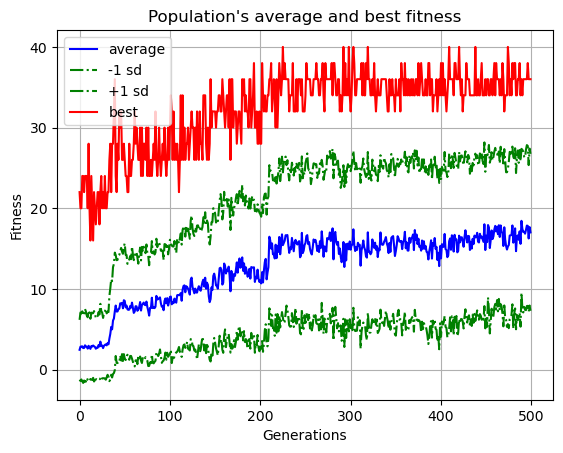

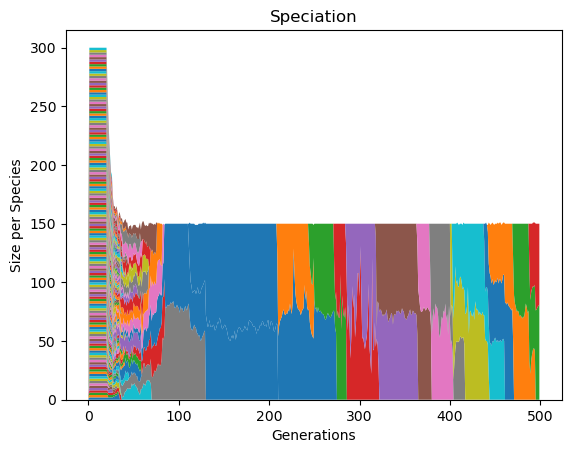

NameError: name 'x_net' is not defined

In [30]:

if __name__ == '__main__':
    
    x=run('config_TN_blocks_holes_columnheight')
    
    #Save the neural network in a pickle
    # Save the winning_neural_network to a file
    with open('my_winner.pkl', 'wb') as f:
        pickle.dump(x_net, f)


    

# Visualize the Best NN

In [38]:
# Load the object from the file
with open('my_winner.pkl', 'rb') as f:
    loaded_object = pickle.load(f)

    print(loaded_object)  # Output: 42

In [3]:
with open('my_winner_del_h.pkl', 'wb') as f:
        pickle.dump(x, f)

NameError: name 'x' is not defined

In [49]:
import random 
x_net = loaded_object
if __name__ == "__main__":
    # Create an instance of Tetris
    env = gym.make("tetris_gymnasium/Tetris", render_mode="human")
    rand_seed = random.randint(0,10000000)
    env.reset(seed = rand_seed)
    
    del_h_hist=0
    reward_hist=0
    start_clip =0
    # Main game loop
    terminated = False
    while not terminated:
        # Render the current state of the game as text
        env.render()
        ### CODE TO GET THE HEIGHT AFTER EACH FRAME 
            #the board doesn't include the piece (the piece is a projection onto the board)
        env1 = FeatureVectorObservation(env) #create an instance of the class

        height_i = env1.calc_height(env.board) #call a function from the class with the board as an input
        height_i = (height_i[4:14])-4 #crop out the padding on either side (the bedrock) and normalize by the 4 layers of bedrock underneath
        prev_height = height_i
        # Pick an action from user input mapped to the keyboard
        action = None
        while action is None:
            key = cv2.waitKey(1)
               
                        ### CODE TO GET THE HEIGHT AFTER EACH FRAME 
            #the board doesn't include the piece (the piece is a projection onto the board)
            env1 = FeatureVectorObservation(env) #create an instance of the class
            
            height_i = env1.calc_height(env.board) #call a function from the class with the board as an input
            height_i = (height_i[4:14])-4 #crop out the padding on either side (the bedrock) and normalize by the 4 layers of bedrock underneath
            #height_hist = np.vstack((height_hist,height_i)) #append to bottom of the historian

            ### Get the current tetromino in a list form and in the position relative to the other blocks
            tetromino = env.active_tetromino
            slices = env.get_tetromino_slices(tetromino, env.x, env.y)
            #Create pseudo_board of just zeros
            only_tetromino = np.zeros((24,18))
            #add the tetromino in its correct place
            only_tetromino[slices] += tetromino.matrix
            #Convert to 1s and 0s
            only_tetromino = np.where(only_tetromino > 0, 1, 0)
            #Sum in each column
            only_tetromino = np.sum(only_tetromino,axis=0)
            #Crop out the empty bedrock
            only_tetromino=only_tetromino[4:14]
            #print(only_tetromino)
            
            #compile the two features together
            i_feat = np.hstack((only_tetromino,height_i)) #this is a one dimensional list of 20 integers

            if start_clip==0:
                if key == ord("a"):
                    action = env.unwrapped.actions.move_left
                    start_clip=1
            else:
                action = np.argmax(x_net.activate(i_feat))
                if action ==2:
                    action = 5

            if (
                cv2.getWindowProperty(env.unwrapped.window_name, cv2.WND_PROP_VISIBLE)
                == 0
            ):
                sys.exit()
        time.sleep(.1) 
        # Perform the action
        observation, reward, terminated, truncated, info = env.step(action)
        reward_hist+=reward
        env1 = FeatureVectorObservation(env) #create an instance of the class
        #Calculate the change in max height only after a block is placed:
        if reward>0:
            height_new = env1.calc_height(env.board) #call a function from the class with the board as an input
            height_new = (height_new[4:14])-4
            #Find the difference in the height 
            max_h_index = np.argmax(height_new)
            i_del_h = height_new[max_h_index] - prev_height[max_h_index]

            #Assign height to previous height for the next step --> Didn't Work
            prev_height = height_new

            #Give positive reward if the height didn't change
            if i_del_h == 0:
                del_h_hist+=2
        #Calculate the holes after each frame --> Only need to return 
        holes_i = env1.calc_holes(env.board)
    # Game over
    print(rand_seed)
    print("Game Over!")
print(del_h_hist)

6271644
Game Over!
32


# Good Seeds:
7906307 --> 38